# qerasure sims (Stim-like lowering instructions)

This notebook demonstrates erasure simulation, lowering with the new Stim-like instruction syntax, and logical-circuit translation.

In [1]:
from pathlib import Path
import sys

repo_root = Path.cwd().resolve().parent
python_src = repo_root / 'python'
if str(python_src) not in sys.path:
    sys.path.insert(0, str(python_src))

import qerasure
import stim

In [2]:
DISTANCE = 3
QEC_ROUNDS = 3
SHOTS = 100
P_TQE = 0.01

code = qerasure.RotatedSurfaceCode(DISTANCE)
noise = qerasure.NoiseParams()
noise.set(qerasure.NoiseChannel.TWO_QUBIT_ERASURE, P_TQE)

sim_params = qerasure.ErasureSimParams(
    code=code,
    noise=noise,
    qec_rounds=QEC_ROUNDS,
    shots=SHOTS,
    seed=12345,
    erasure_selection=qerasure.ErasureQubitSelection.DATA_QUBITS,
)
erasure_results = qerasure.ErasureSimulator(sim_params).simulate()

In [3]:
# New Stim-like lowering instruction syntax.
program = qerasure.SpreadProgram()
program.append('Z_ERROR(0.5) X_1; Z_ERROR(0.5) X_2')
program.append('COND_X_ERROR(0.5) Z_1; ELSE_X_ERROR(1.0) Z_2')

reset = qerasure.LoweredErrorParams(qerasure.PauliError.DEPOLARIZE, 0.75)
lowering_params = qerasure.LoweringParams(program, reset)
lowering_result = qerasure.Lowerer(code, lowering_params).lower(erasure_results)

(<Figure size 1200x800 with 3 Axes>,
 (<Axes: title={'center': 'Erasure Timeline (shot=0, qubits=17)'}, ylabel='Qubit index (subset order)'>,
  <Axes: xlabel='Timestep', ylabel='Events'>))

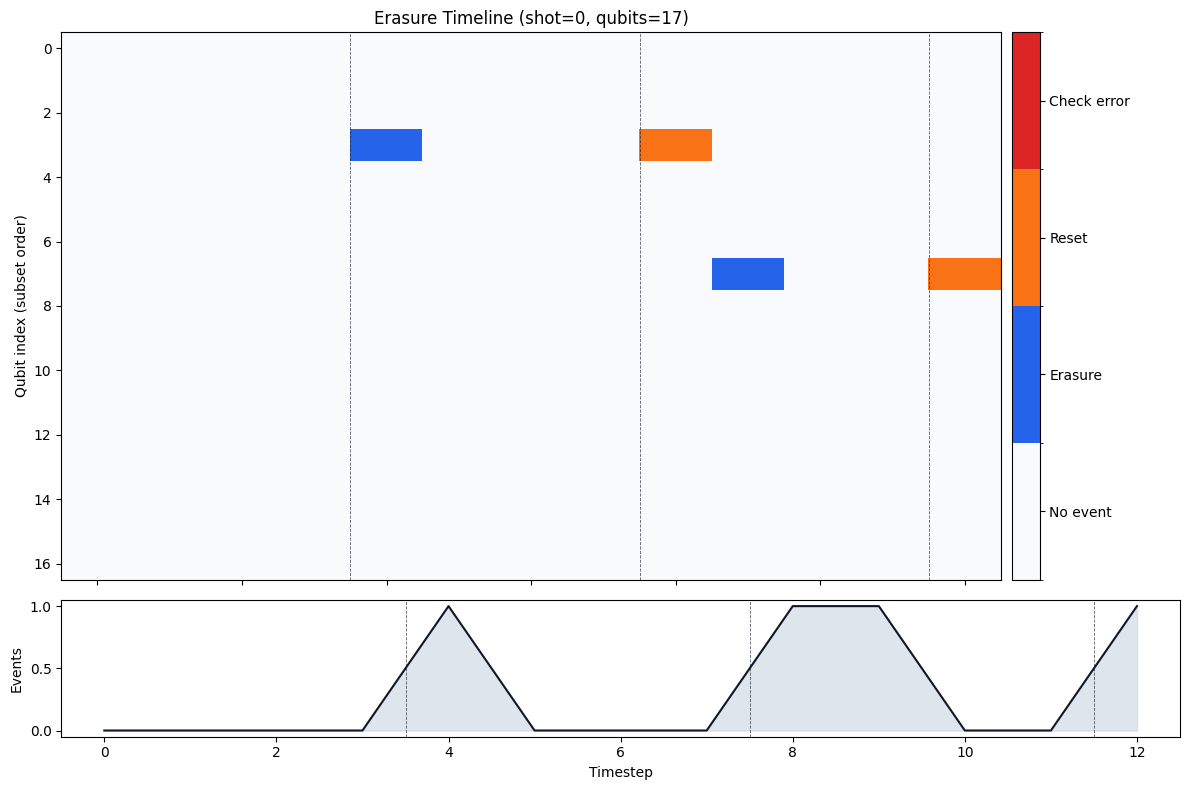

In [4]:
shot_index = 0
qerasure.visualize_erasures(erasure_results, sim_params, shot_idx=shot_index)

(<Figure size 1200x800 with 3 Axes>,
 (<Axes: title={'center': 'Lowering Timeline (shot=0, qubits=17)'}, ylabel='Qubit index (subset order)'>,
  <Axes: xlabel='Timestep', ylabel='Events'>))

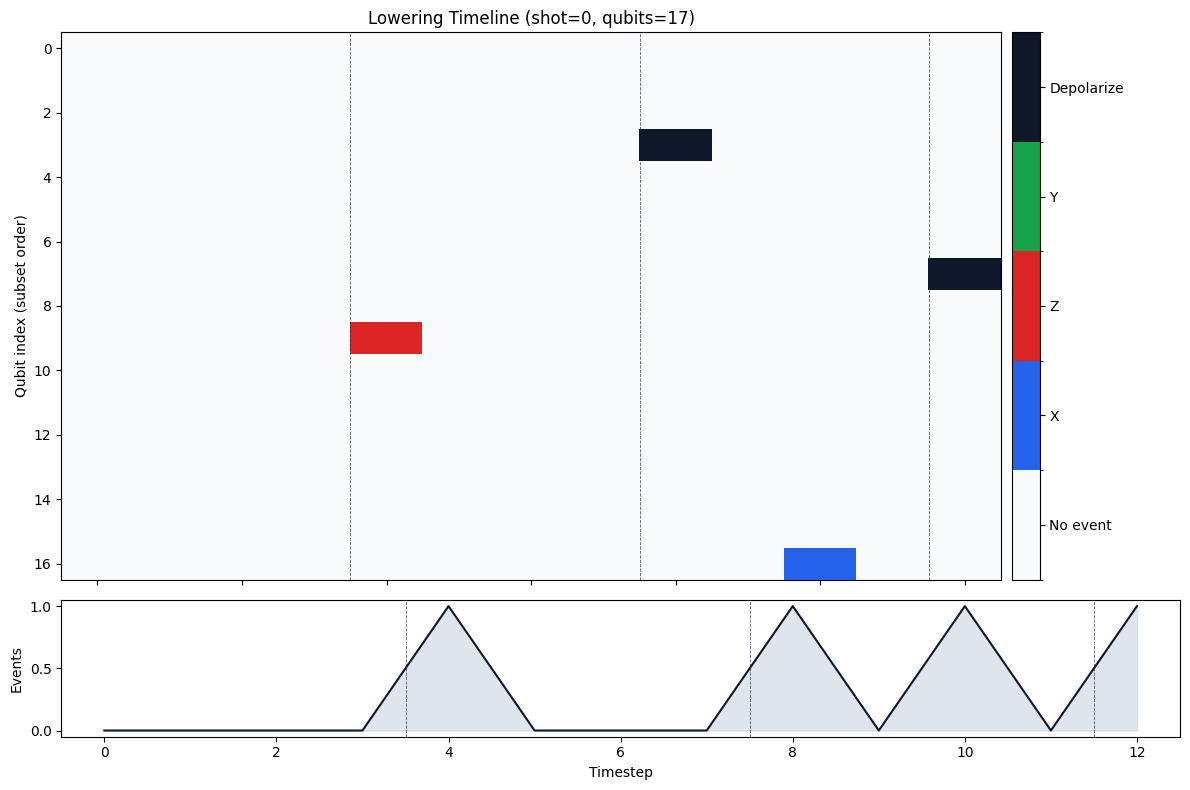

In [5]:
qerasure.visualize_lowering(lowering_result, sim_params, shot_idx=shot_index)

In [6]:
logical_circuit = qerasure.build_logical_stabilizer_circuit_object(
    code=code, lowering_result=lowering_result, shot_index=0
)
print(str(logical_circuit))

H 9 10 11 12
CX 9 3 10 1 11 5 2 14 4 15 8 16 10 0 11 4 12 2 1 13 5 14 7 15 9 6 10 4 11 8 1 14 3 15 7 16 10 3 11 7 12 5 0 13 4 14 6 15
H 9 10 11 12
MR 9 10 11 12 13 14 15 16
DETECTOR rec[-4]
DETECTOR rec[-3]
DETECTOR rec[-2]
DETECTOR rec[-1]
H 9 10 11 12
CX 9 3 10 1 11 5 2 14 4 15 8 16
Z_ERROR(1) 9
CX 10 0 11 4 12 2 1 13 5 14 7 15 9 6 10 4 11 8 1 14 3 15 7 16 10 3 11 7 12 5 0 13 4 14 6 15
H 9 10 11 12
DEPOLARIZE1(1) 3
MR 9 10 11 12 13 14 15 16
DETECTOR rec[-4] rec[-12]
DETECTOR rec[-3] rec[-11]
DETECTOR rec[-2] rec[-10]
DETECTOR rec[-1] rec[-9]
H 9 10 11 12
CX 9 3 10 1 11 5 2 14 4 15 8 16 10 0 11 4 12 2 1 13 5 14 7 15 9 6 10 4 11 8 1 14 3 15 7 16
X_ERROR(1) 16
CX 10 3 11 7 12 5 0 13 4 14 6 15
H 9 10 11 12
DEPOLARIZE1(1) 7
MR 9 10 11 12 13 14 15 16
DETECTOR rec[-4] rec[-12]
DETECTOR rec[-3] rec[-11]
DETECTOR rec[-2] rec[-10]
DETECTOR rec[-1] rec[-9]
M 0 1 2 3 4 5 6 7 8
DETECTOR rec[-13] rec[-9] rec[-8]
DETECTOR rec[-12] rec[-8] rec[-7] rec[-5] rec[-4]
DETECTOR rec[-11] rec[-6] rec[-5] re

In [7]:
virtual_circuit = qerasure.build_virtual_decoder_stim_circuit_object(
    code=code,
    qec_rounds=QEC_ROUNDS,
    spread_program=program,
    two_qubit_erasure_probability=P_TQE,
    condition_on_erasure_in_round=True,
)
print(str(virtual_circuit))

H 9 10 11 12
CX 9 3 10 1 11 5 2 14 4 15 8 16
Z_ERROR(0.168345) 10
E(0)
ELSE_CORRELATED_ERROR(0)
E(0.251256) X14
ELSE_CORRELATED_ERROR(0)
Z_ERROR(0.168345) 9
E(0)
ELSE_CORRELATED_ERROR(0)
E(0.126891) X15
ELSE_CORRELATED_ERROR(0)
Z_ERROR(0.168345) 11
E(0)
ELSE_CORRELATED_ERROR(0)
E(0.251256) X16
ELSE_CORRELATED_ERROR(0)
CX 10 0 11 4 12 2 1 13 5 14 7 15
Z_ERROR(0.251256) 10
E(0)
ELSE_CORRELATED_ERROR(0)
E(0.335006) X13
ELSE_CORRELATED_ERROR(0)
Z_ERROR(0.5) 12
E(0)
ELSE_CORRELATED_ERROR(0)
Z_ERROR(0.252512) 11
E(0)
ELSE_CORRELATED_ERROR(0)
E(0.335006) X14
ELSE_CORRELATED_ERROR(0)
E(0.168345) X15
ELSE_CORRELATED_ERROR(0)
CX 9 6 10 4 11 8 1 14 3 15 7 16
E(0)
ELSE_CORRELATED_ERROR(1) X14
E(0.335006) X15
ELSE_CORRELATED_ERROR(0)
Z_ERROR(0.376878) 10
E(0)
ELSE_CORRELATED_ERROR(0)
Z_ERROR(0.251256) 9
E(0)
ELSE_CORRELATED_ERROR(0)
E(0)
ELSE_CORRELATED_ERROR(1) X16
Z_ERROR(0.5) 11
E(0)
ELSE_CORRELATED_ERROR(0)
CX 10 3 11 7 12 5 0 13 4 14 6 15
E(0.5) X13
ELSE_CORRELATED_ERROR(0)
Z_ERROR(0.5) 10
E(0